## Урок 6. Градиентный бустинг. AdaBoost.

### Домашнее задание<a class='anchor' id='features'>

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров. 


In [2]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.25
)

In [6]:
n_trees_ = [1, 3, 5, 10, 50, 100]
# list(map(print, n_trees_))
print('Количество  деревьев:',*list(map(lambda x: f'{x:>20}', n_trees_)), sep = ' ')
# print(f'')

for depth in range(1,8,2):
    print(f'Глубина деревьев {depth:>3}:', end = ' ')
    for n_tree in n_trees_:
        coefs=[1]*n_tree
        print(f'{n_tree:>20}', end = ' ')
    print()


Количество  деревьев:                    1                    3                    5                   10                   50                  100
Глубина деревьев   1:                    1                    3                    5                   10                   50                  100 
Глубина деревьев   3:                    1                    3                    5                   10                   50                  100 
Глубина деревьев   5:                    1                    3                    5                   10                   50                  100 
Глубина деревьев   7:                    1                    3                    5                   10                   50                  100 


In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)
mean_squared_error

<function __main__.mean_squared_error(y_real, prediction)>

In [16]:
def bias(y_train, target):
    return (y_train - target)

In [17]:
def get_errors(X_train, X_test, y_train, y_test, eta, n_trees):
    all_train_err={}
    all_test_err={}
    print('Количество  деревьев:',*list(map(lambda x: f'{x:>20}', n_trees)), sep = ' ')
    for depth in range(1,8,2):
        train_err=[]
        test_err=[]
        print(f'Глубина деревьев {depth:>3}:', end = ' ')
        for n_tree in n_trees:
            start_time = time.time()

            coefs=[1]*n_tree
            trees, train_errors, test_errors=gb_fit(n_tree, depth, X_train, X_test, y_train, y_test, coefs, eta)
            train_pred = gb_predict(X_train, trees, coefs, eta)
            train_err.append(mean_squared_error(y_train, train_pred))
            test_pred=gb_predict(X_test, trees, coefs, eta)
            test_err.append(mean_squared_error(y_test, test_pred))
            
            finish_time = time.time()
            time_spent = finish_time - start_time
            print(f'      {datetime.timedelta(seconds=time_spent)}', end = ' ')

        print() # Завершающий штрих в таблице-прогресс-баре

        all_train_err[depth]=train_err
        all_test_err[depth]=test_err
    return all_train_err, all_test_err,eta,n_trees

In [18]:
def plot_errors_graphics(train_err,test_err,eta,n_trees):
    fif, ax= plt.subplots(figsize = (16, 18))
    plt.subplot(2,2,1)
    for key in train_err.keys():
        plt.plot(n_trees, train_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тренировочной выборке \nв зависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
        
    plt.subplot(2,2,2)
    for key in test_err.keys():    
        plt.plot(n_trees, test_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тестовой выборке \nв зависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()

    delta_err = {}
    for key_name in list(tr_err.keys()):
        delta_err[key_name] = np.abs(np.array(tr_err.get(key_name))-np.array(tst_err.get(key_name)))

    plt.subplot(2,2,(3,4))
    for key in test_err.keys():    
        plt.plot(n_trees, delta_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Разность между ошибками трейна и теста')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
    plt.show()    

In [19]:
n_trees = [1, 5, 10, 30, 50, 100]
eta = 0.1
tr_err, tst_err, eta, n_trees = get_errors(X_train, X_test, y_train, y_test, eta, n_trees)

Количество  деревьев:                    1                    5                   10                   30                   50                  100
Глубина деревьев   1:       0:00:00.054191       0:00:00.779956       0:00:07.421671       0:00:30.358793       0:01:19.512458       0:05:11.407891 
Глубина деревьев   3:       0:00:00.034130       0:00:00.808614       0:00:02.943437       0:00:27.787685       0:01:17.685233       0:05:10.240308 
Глубина деревьев   5:       0:00:00.065539       0:00:00.917629       0:00:02.925059       0:00:27.943817       0:01:17.637925       0:05:10.563670 
Глубина деревьев   7:       0:00:00.053486       0:00:01.202939       0:00:02.932253       0:00:28.299423       0:01:18.228638       0:05:09.474713 


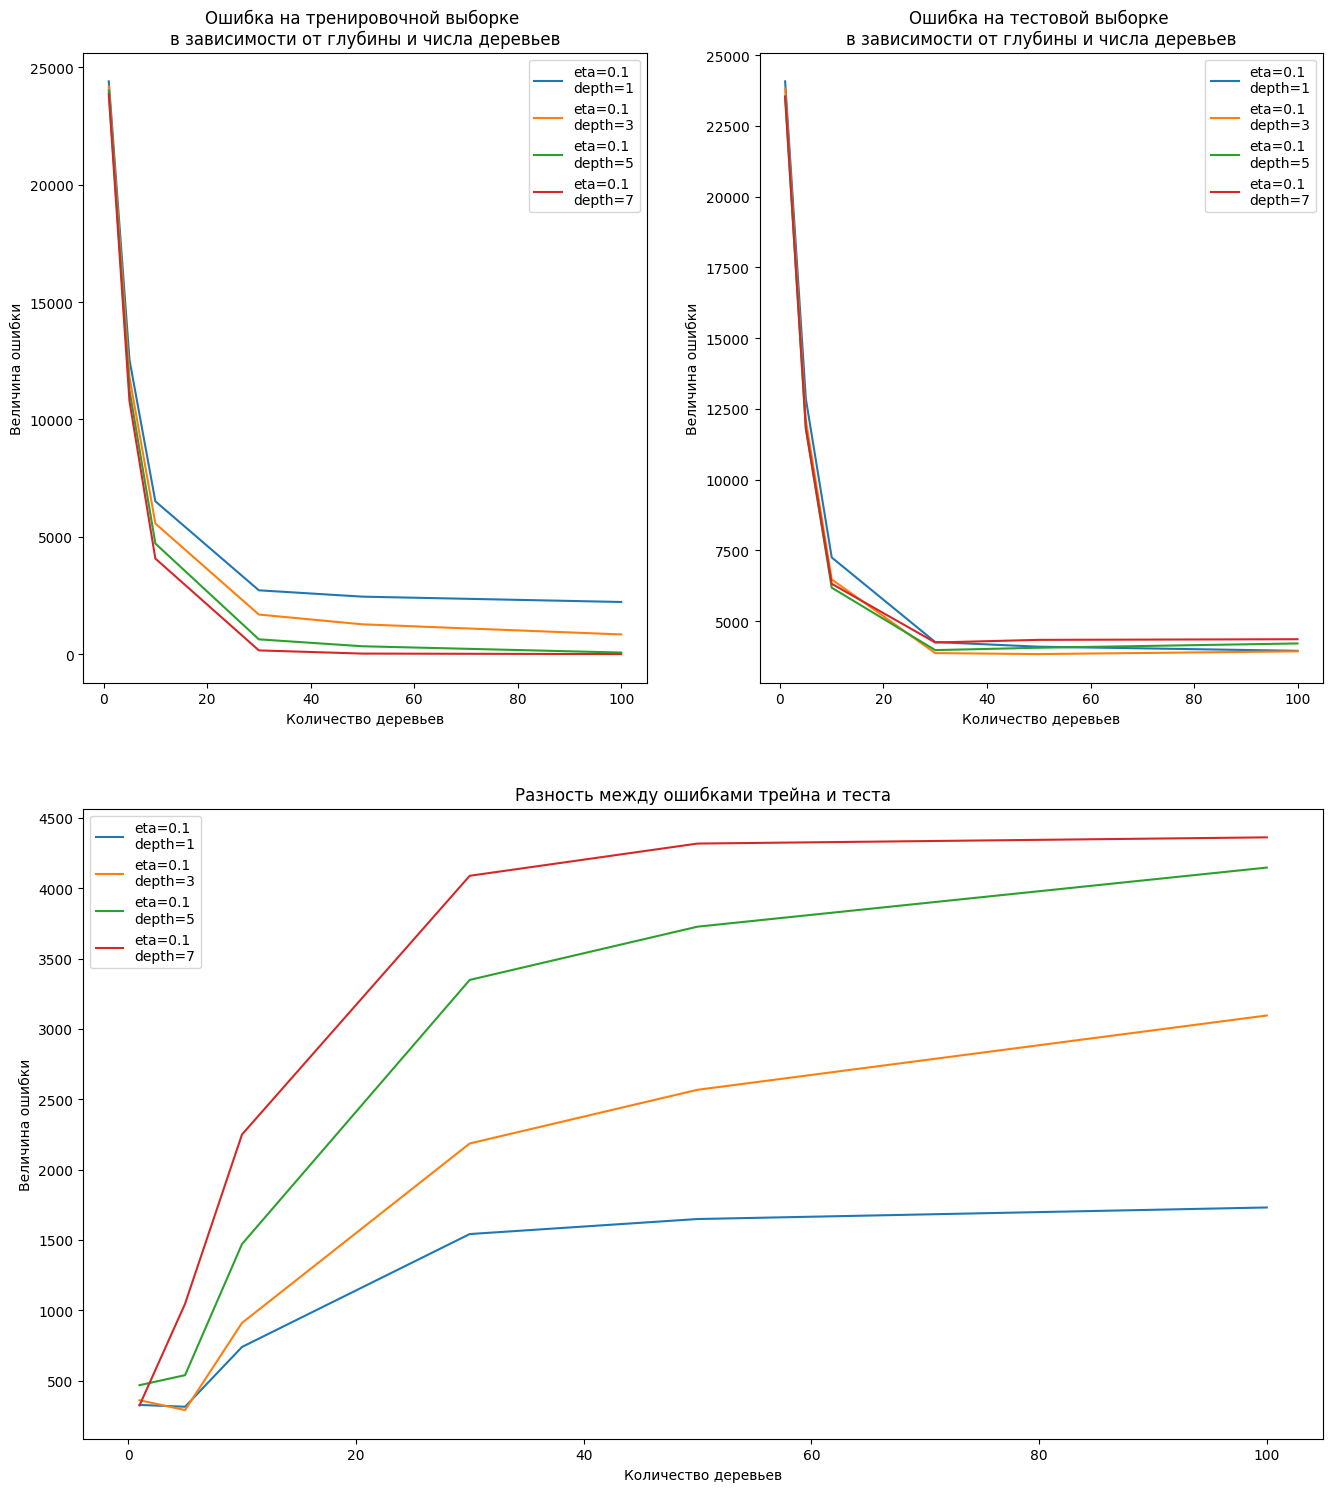

In [24]:
plot_errors_graphics(tr_err, tst_err, eta, n_trees)

**Вывод:** *количество деревьев в ансамбле уменьшается с увеличением глубины деревьев. Т.е. для деревьев глубины 1 после 30-ти деревьев ошибка между трейном и тестом перестает уменьшаться. Для глубины 3 оптимальное количество деревьев около 10. Для глубины 5 - 5. И для глубины 7 минимальная разница между ошибками трейна и теста - 5.*

2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [25]:
def gb_sgd_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # Определяем случайные индексы
        random_idx = set()
        
        while len(random_idx) < X_train.shape[0]//2:
            random_idx.add(np.random.randint(0, X_train.shape[0]))
        random_idx=list(random_idx)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[random_idx], y_train[random_idx])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[random_idx], bias(y_train[random_idx], target[random_idx]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [26]:
n_trees = 100
max_depth = 4
#eta = 0.1
coefs = [1]*n_trees

trees, tr_err, tst_err=gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
sgd_trees, sgd_tr_err, sgd_tst_err=gb_sgd_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [27]:
def get_error_plot(n_trees, train_err, test_err):
    plt.figure(figsize=(16,10))
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='sgd_train error')
    plt.legend(loc='upper right')
    plt.show()

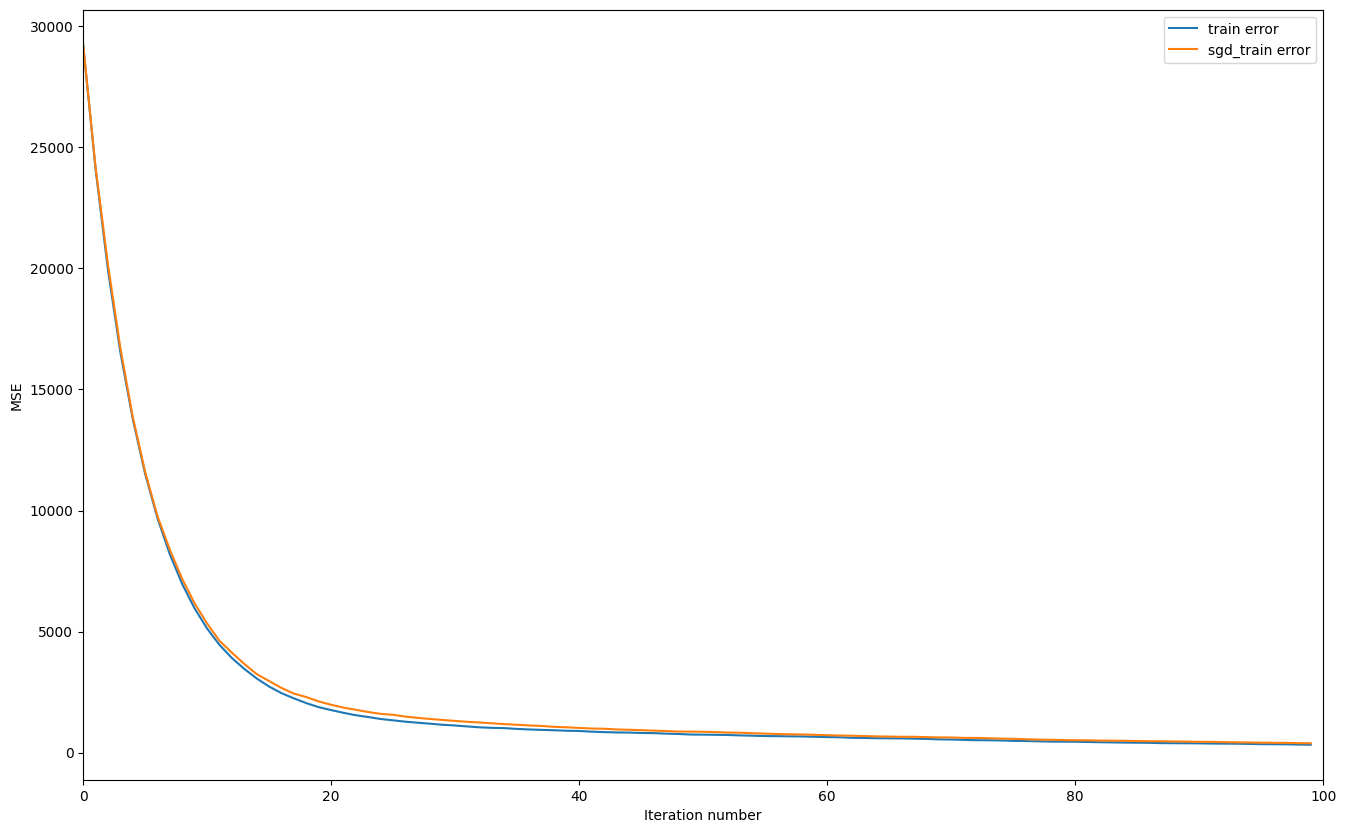

In [28]:
get_error_plot(n_trees, tr_err, sgd_tr_err)

**Вывод:** *видимые именения по сравнению с обычным методом незначительны.*

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [33]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [35]:
def gb_predict(X, trees_list, eta):
       
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [36]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [37]:
def residual(y, z):
    return - (z - y)

In [38]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [39]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [40]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [41]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1118.2965832305063
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6182.226129264211


In [42]:
# Вариант 1 - Исходный
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [43]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 2.71 s, sys: 50.8 ms, total: 2.76 s
Wall time: 2.71 s


([29670.465256797583,
  2832.9127467447106,
  2411.4013444590764,
  2216.6270774511086,
  1925.1743477605082,
  1665.4836028861448,
  1583.291623655693,
  1438.1913381122615,
  1279.2640010259693,
  1204.6222501839427],
 [27297.27027027027,
  4249.042991054678,
  4134.620105629738,
  4350.82761428838,
  4581.757526263751,
  4850.681833597457,
  5219.580300642902,
  5463.6813661453225,
  5626.457992489821,
  5881.080304600153])

In [44]:
# Вариант 2 - применение predict к вектору X + apply_along_axis для суммы предсказаний
def gb_predict(X, trees_list, eta):
    f = np.array([eta * t.predict(X) for t in trees_list])
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [45]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 72.2 ms, sys: 1.96 ms, total: 74.1 ms
Wall time: 87 ms


([29670.465256797583,
  2832.9127467447106,
  2411.4013444590764,
  2216.6270774511086,
  1925.1743477605082,
  1665.4836028861448,
  1583.291623655693,
  1438.1913381122615,
  1279.2640010259693,
  1204.6222501839427],
 [27297.27027027027,
  4249.042991054678,
  4134.620105629738,
  4350.82761428838,
  4581.757526263751,
  4850.681833597457,
  5219.580300642902,
  5463.6813661453225,
  5626.457992489821,
  5881.080304600153])

In [46]:
# Вариант 3 - lambda + map + apply_along_axis
def gb_predict(X, trees_list, eta):
    t_l = lambda t: eta * t.predict(X)
    f = np.array(list(map(t_l, trees_list)))
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [47]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 67.5 ms, sys: 0 ns, total: 67.5 ms
Wall time: 70.4 ms


([29670.465256797583,
  2832.9127467447106,
  2411.4013444590764,
  2216.6270774511086,
  1925.1743477605082,
  1665.4836028861448,
  1583.291623655693,
  1438.1913381122615,
  1279.2640010259693,
  1204.6222501839427],
 [27297.27027027027,
  4249.042991054678,
  4134.620105629738,
  4350.82761428838,
  4581.757526263751,
  4850.681833597457,
  5219.580300642902,
  5463.6813661453225,
  5626.457992489821,
  5881.080304600153])

In [48]:
# Вариант 4 - vectorized lambda + map
def gb_predict(X, trees_list, eta):
    t_l = lambda t: eta * t.predict(X)
    v_t_l = np.vectorize(t_l)
    f = np.array(list(map(v_t_l, trees_list)))
    predictions = np.apply_along_axis(sum, 0, f)

    return predictions

In [49]:
%%time

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
train_errors, test_errors

CPU times: user 76.6 ms, sys: 0 ns, total: 76.6 ms
Wall time: 79.9 ms


([29670.465256797583,
  2832.9127467447106,
  2411.4013444590764,
  2216.6270774511086,
  1925.1743477605082,
  1665.4836028861448,
  1583.291623655693,
  1438.1913381122615,
  1279.2640010259693,
  1204.6222501839427],
 [27297.27027027027,
  4249.042991054678,
  4134.620105629738,
  4350.82761428838,
  4581.757526263751,
  4850.681833597457,
  5219.580300642902,
  5463.6813661453225,
  5626.457992489821,
  5881.080304600153])

**Вывод:** *самый быстрый - вариант 3. Основной прирост скорости в примении predict на векторе и использование apply_along_axis для суммы предсказаний по деревьем.*